In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils import resample

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')

Function to shift death count outcome forward by 1 year. **Note**: function removes any zipcodes without full 6 years from the data set, because it messes up the shifting and shouldnt be included in the model.

In [ ]:
def remove_zip_and_shift(df):
    # find zips with missing years between 2011 - 2016
    zipp = list(np.unique(df.zip))
    zs = []
    for z in zipp:
        sub = df[df.zip == z]
        if np.unique(sub.AYEAR).shape[0] != 6:
            zs.append(z)

    # find zips that have all 6 years
    zip_to_keep = list(np.setdiff1d(list(df.zip.values),zs))

    # only keep data with zips for all 6 years
    sub_zip = df[df.zip.isin(zip_to_keep)]

    # shift death count and dead variables by 1 year, so outcome is adjusted
    zip_df_new = sub_zip.copy()
    zip_df_new['death'] = zip_df_new.groupby(zip_df_new['zip'])['death'].shift(-1)
    zip_df_new['dead'] = zip_df_new.groupby(zip_df_new['zip'])['dead'].shift(-1)

    return zip_df_new

Functions to standardize.

In [3]:
def standardize(non_binary_predictors, X_train, X_test=None):
    
    scaler = StandardScaler().fit(X_train[non_binary_predictors])
    
    # if x_test is passed in, or just x_train 
    if X_test is not None:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        X_test[non_binary_predictors] = scaler.transform(X_test[non_binary_predictors])
        return X_train, X_test
    else:
        X_train[non_binary_predictors] = scaler.transform(X_train[non_binary_predictors])
        return X_train  

def split_and_standardize(df, x_cols, y_col, non_binary_preds, interact_cols=None):
    # separate into X and y
    X = df[x_cols]
    y = df[y_col]
    
    if interact_cols != None:
        for i,c in enumerate(interact_cols.keys()):
            X[c] = X[interact_cols[c][0]]*X[interact_cols[c][1]]
    
    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=109)
    
    # standardize
    X_train_standardized, X_test_standardized = standardize(non_binary_preds, X_train,X_test)
    
    return X_train_standardized, y_train, X_test_standardized, y_test

In [4]:
df_train = pd.read_csv('zip_train_v2.csv')
df_test= pd.read_csv('zip_test_v2.csv')

In [5]:
x_col = ['sex', 'age','poverty', 'popdensity', 'medianhousevalue', 
        'medhouseholdincome', 'pct_owner_occ','education',
        'smoke_rate', 'mean_bmi', 'rmax', 'pr', 'race_0', 'race_1', 'race_2',
        'race_3', 'race_4', 'race_5', 'race_6','ICU_DAY', 'CCI_DAY', 'LOS', 
        'Parkinson_pdx2dx_25','Alzheimer_pdx2dx_25', 'Dementia_pdx2dx_25', 'CHF_pdx2dx_25',
       'AMI_pdx2dx_25', 'COPD_pdx2dx_25', 'DM_pdx2dx_25', 'Stroke_pdx2dx_25',
       'CVD_pdx2dx_25', 'Ischemic_stroke_pdx2dx_25','Hemo_Stroke_pdx2dx_25',
        'neo_140_149', 'neo_150_159', 'neo_160_165',
       'neo_170_176', 'neo_179_189', 'neo_190_199', 'neo_200_209',
       'neo_210_229', 'neo_230_234', 'neo_235_238', 'neo_239','pm25_summer_4y_avg', 
       'pm25_winter_4y_avg', 'pm25_fall_4y_avg', 'pm25_spring_4y_avg','ozone_summer_4y_avg', 'ozone_winter_4y_avg', 
       'ozone_fall_4y_avg', 'ozone_spring_4y_avg','no2_summer_4y_avg', 'no2_winter_4y_avg', 'no2_fall_4y_avg', 
       'no2_spring_4y_avg', 'summer_tmmx_4y_avg','summer_rmax_4y_avg', 'winter_tmmx_4y_avg', 'winter_rmax_4y_avg']

y_col = 'death'
non_binary_preds = x_col

# split into train and test and standardize
X_train_standardized, y_train, X_test_standardized, y_test = split_and_standardize(df_train, x_col, y_col, non_binary_preds)


**Bagging & Simple Decision Trees**

In [6]:
def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):

    #n_depths = len(tree_depth)
    np.random.seed(random_seed)
    bagging_train = np.zeros((X_train_standardized.shape[0], n_trees))
    bagging_test = np.zeros((X_test_standardized.shape[0], n_trees))

    bagging_models = []

    for i in range(n_trees):
        bootstrapped_X, bootstrapped_y = resample(X_train_standardized, y_train)
        fitted_model = DecisionTreeRegressor(max_depth=tree_depth).fit(bootstrapped_X, bootstrapped_y)
        bagging_models.append(fitted_model)

        bagging_train[:,i] = fitted_model.predict(X_train_standardized)
        bagging_test[:,i] = fitted_model.predict(X_test_standardized)
    
    return  pd.DataFrame(bagging_train[:,:], columns=[f"model{x}" for x in range(n_trees)]) \
        , pd.DataFrame(bagging_test[:,:], columns=[f"model{x}" for x in range(n_trees)]) \
        , bagging_models

In [7]:
n_trees = 30 
tree_depth = 10
bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees, tree_depth,  random_seed= 0)
display(bagging_train_df.head())
display(bagging_test_df.head())

,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,...,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29
0,21.662941,25.194811,26.079620,25.656647,26.582811,25.510121,25.024586,25.596203,23.675429,24.271733,...,23.296954,27.371179,25.720207,23.094692,27.194985,22.924812,22.113158,21.179281,26.404125,25.100390
1,25.734028,25.194811,27.473200,25.581081,22.870130,23.440533,31.902688,25.629317,22.197279,26.603886,...,29.974879,26.359096,25.411304,26.779393,21.257246,28.135057,25.893921,24.470155,29.443585,25.560197
2,3216.610169,2660.110803,3085.016949,2567.183607,2654.869565,2680.916031,2784.661765,2945.231746,2893.962825,2900.990476,...,2652.783290,3195.114894,3020.882759,3012.301639,3121.776316,2642.363077,2966.076503,2681.777778,3357.875000,3191.340000
3,863.916898,908.814491,761.954717,801.024155,730.521327,787.432258,886.321826,860.228571,724.328571,750.839248,...,737.085366,926.436950,853.476378,841.211600,794.008264,784.048193,749.232990,755.104839,917.539474,823.341682
4,85.485597,94.775457,89.237557,81.996692,85.017403,79.358300,78.115804,75.242938,92.394449,99.111342,...,80.859589,89.470075,89.251232,107.590909,91.720617,88.358261,91.282974,120.766816,99.087068,103.099634


,model0,model1,model2,model3,model4,model5,model6,model7,model8,model9,...,model20,model21,model22,model23,model24,model25,model26,model27,model28,model29
0,373.382979,301.190383,307.015564,356.058552,311.457746,289.875000,436.688406,441.140845,319.632860,358.792683,...,375.849785,460.393443,343.821682,277.417722,325.956325,378.238289,248.666667,421.339450,396.848485,250.487805
1,1680.800000,1636.000000,1874.769231,1598.117647,1838.571429,1794.857143,1802.769231,1583.172414,2292.000000,1770.857143,...,2018.488889,1679.368421,1632.000000,2098.956522,1613.600000,1488.000000,1236.000000,1754.950820,1611.428571,1632.000000
2,1410.479290,1597.962887,1887.090909,1782.109325,1598.137652,1870.941176,1514.381853,1623.269036,1483.111501,1601.785714,...,1485.456954,1494.059406,1186.000000,1342.784810,1328.188235,1574.559557,1464.883436,1451.521951,1225.378723,1966.530612
3,15.019022,17.054645,18.782518,13.209448,12.599847,13.440918,17.039024,16.033605,17.840968,14.368564,...,17.690755,12.845574,18.868298,12.866667,12.447982,12.692359,16.255419,14.467213,14.797863,11.265144
4,11.445183,10.129936,9.740389,13.209448,10.076336,10.482293,10.247750,10.142798,9.778886,10.339442,...,10.763249,11.783005,10.193673,10.178496,12.447982,9.311026,11.871586,11.164856,9.392903,11.265144


In [8]:
bagging_train_pred = np.mean(bagging_train_df, axis=1) 
bagging_test_pred = np.mean(bagging_test_df, axis=1)

bagging_accuracy_train = r2_score(y_train, bagging_train_pred)
bagging_accuracy_test = r2_score(y_test, bagging_test_pred)

print(f"Bagging {n_trees} of depth {tree_depth} achieved a score of {bagging_accuracy_train} on the train set.")
print(f"Bagging {n_trees} of depth {tree_depth} achieved a score of {bagging_accuracy_test} on the test set.")


Bagging 30 of depth 10 achieved a score of 0.9407105947635653 on the train set.
Bagging 30 of depth 10 achieved a score of 0.9255025421070099 on the test set.


In [9]:
top_predictors_bagging = [X_train_standardized.columns[model.tree_.feature[0]] for model in bagging_models]
top_predictors_bagging_df = pd.DataFrame(pd.Series(top_predictors_bagging).value_counts(), columns=['Count'])
display(top_predictors_bagging_df)

,Count
CVD_pdx2dx_25,30


Top predictor split on is always CVD... let's do Random Forest!

**Random Forest Regression**


In [21]:
n_trees = 60
n_depth = 18

# fit random forest model
rf_model = RandomForestRegressor(n_estimators = n_trees, max_depth = n_depth, max_features='sqrt').fit(X_train_standardized, y_train)

# evaluate model
rf_train_score = rf_model.score(X_train_standardized, y_train)
rf_test_score = rf_model.score(X_test_standardized, y_test)

# predict on test
rf_test_pred = rf_model.predict(X_test_standardized)

In [22]:
rf_train_score, rf_test_score

(0.9836299072656884, 0.9336238389047776)

In [24]:
cols = X_train_standardized.columns
top_pred = [cols[rf_model.estimators_[i].tree_.feature[0]] for i in range(n_trees)]

pd.DataFrame(pd.Series(top_pred).value_counts(), columns=['Counts'])

,Counts
Ischemic_stroke_pdx2dx_25,10
CVD_pdx2dx_25,9
Alzheimer_pdx2dx_25,6
DM_pdx2dx_25,5
CHF_pdx2dx_25,4
Parkinson_pdx2dx_25,3
Stroke_pdx2dx_25,3
COPD_pdx2dx_25,3
neo_239,3
Dementia_pdx2dx_25,3


In [ ]:
# grid search and cross validation on random forest
# https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb

# VISUALIZE TREE
# https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

Grid Search Code 

- This takes forever to run, but will help you find optimal parameters

In [9]:
gsr = GridSearchCV(
        estimator = RandomForestRegressor(),
        param_grid={'max_depth': range(10,15),'n_estimators': (30,40,50,60)}),
        cv=5)

gsr_fitted = gsr.fit(X_train_standardized, y_train)
best_params = gsr_fitted.best_params_

**Boosting and ADA Boost**

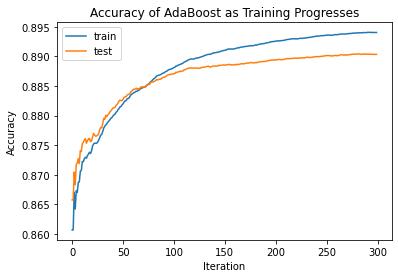

In [15]:
fitted_ada = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=300,
    learning_rate=0.05).fit(X_train_standardized, y_train)

train_scores = list(fitted_ada.staged_score(X_train_standardized, y_train))
test_scores = list(fitted_ada.staged_score(X_test_standardized, y_test))

plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Accuracy of AdaBoost as Training Progresses")
plt.legend()

In [16]:
max(train_scores), max(test_scores)

(0.8940957607075577, 0.8904294697141126)

Gradient Boosting (Regressor)

https://blog.paperspace.com/implementing-gradient-boosting-regression-python/

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

In [22]:
gbr_model = GradientBoostingRegressor(learning_rate=0.1,n_estimators=200, max_depth=10,max_features='sqrt')
gbr_model.fit(X_train_standardized, y_train)

GradientBoostingRegressor(max_depth=10, max_features='sqrt', n_estimators=200)

In [23]:
# test score
gbr_model.score(X_test_standardized, y_test)

0.9558188885929826

In [38]:
# train score
gbr_model.score(X_train_standardized, y_train)

0.9949337075381884

In [39]:
gbr_train_score = np.zeros((200,), dtype=np.float64)
for i, y_pred in enumerate(gbr_model.staged_predict(X_train_standardized)):
    gbr_train_score[i] = r2_score(y_train, y_pred)
    
gbr_test_score = np.zeros((200,), dtype=np.float64)
for i, y_pred in enumerate(gbr_model.staged_predict(X_test_standardized)):
    gbr_test_score[i] = r2_score(y_test, y_pred)
    

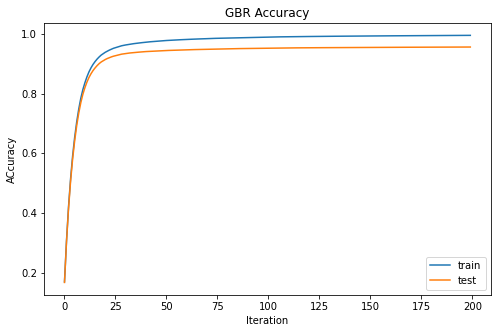

In [41]:
f, ax = plt.subplots(1, figsize=(8,5))
ax.plot(gbr_train_score,label='train')
ax.plot(gbr_test_score,label='test')
ax.set_xlabel('Iteration')
ax.set_ylabel('ACcuracy')
ax.set_title("GBR Accuracy")
plt.legend()
plt.show()
# f.savefig('gbr_results.png')

Text(0.5, 1.0, 'Feature Importance (MDI)')

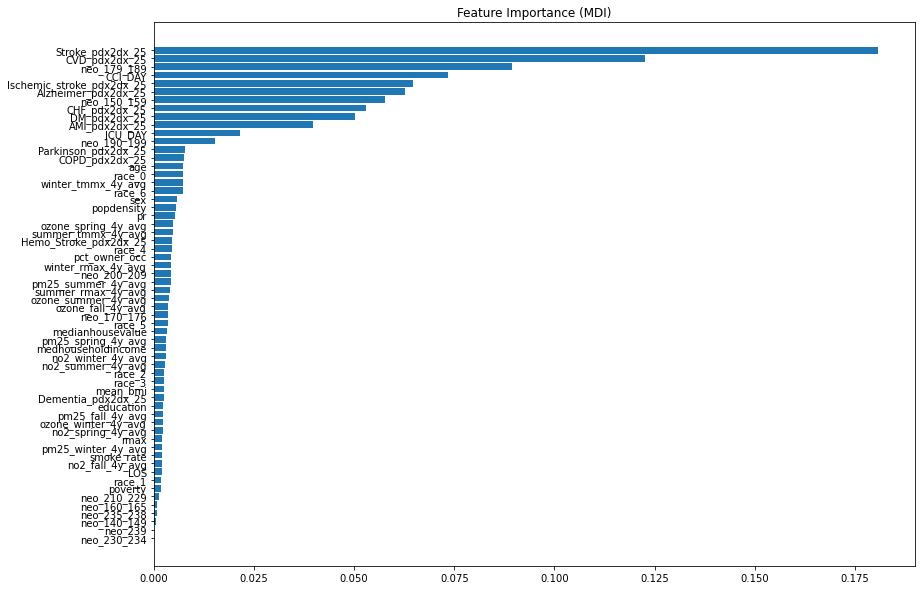

In [37]:
gbr_feature_importance = gbr_model.feature_importances_
sorted_idx = np.argsort(gbr_feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.barh(pos, gbr_feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train_standardized.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

Looks like stroke, CVD, and neoplasms related to Genitourinary Organs are top predictors 